# IN6227 Data Mining — Assignment 1

In [23]:
# Environment Setup and Library Import
import warnings
warnings.filterwarnings("ignore")

import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import __version__ as sklearn_version
from packaging import version

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             classification_report, confusion_matrix)

print("✅ Environment Setup Complete")

✅ Environment Setup Complete


## 1) Load UCI Adult (Census Income) train/test

In [24]:
# Load the dataset
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_url  = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

def try_load_adult():

    try:
        train_df = pd.read_csv(train_url, header=None, names=columns,
                               na_values='?', skipinitialspace=True)
        test_df  = pd.read_csv(test_url,  header=None, names=columns,
                               na_values='?', skipinitialspace=True, skiprows=1)
        print("Loaded from UCI URLs.")
        return train_df, test_df
    except Exception as e:
        print("URL load failed:", e)

train_df, test_df = try_load_adult()
print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

Loaded from UCI URLs.
Train shape: (32561, 15)
Test  shape: (16281, 15)


## 2) Clean and normalize labels

In [25]:
# Clean and normalize labels
def clean_labels(df):
    # Normalize income labels: strip whitespace; remove trailing '.' if any.
    df = df.copy()
    df['income'] = df['income'].astype(str).str.strip().str.replace('.', '', regex=False)
    # Normalize all string columns: strip leading/trailing spaces
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.strip()
    return df

train_df = clean_labels(train_df)
test_df  = clean_labels(test_df)

train_df.head(3)

# Merge data
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("\n📊 Basic Information of the Dataset:")
print(full_df.info())

print("\n🎯 Target Variable Distribution:")
print(full_df["income"].value_counts())
print(f"Unique values of the target variable: {full_df['income'].unique()}")


📊 Basic Information of the Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB
None

🎯 Target Variable Distribution:
income
<=50K    37

## 3) Handle missing values

In [26]:
# Handle missing values
def handle_missing_values(df):
    df = df.copy()
    for col in df.columns:
        if df[col].isna().any():
            if df[col].dtype != 'object':
                df[col].fillna(df[col].median(), inplace=True)
            else:
                df[col].fillna(df[col].mode().iloc[0], inplace=True)
    return df

train_df = handle_missing_values(train_df)
test_df  = handle_missing_values(test_df)

print("Missing values (train):")
print(train_df.isna().sum().sum())
print("Missing values (test):")
print(test_df.isna().sum().sum())

Missing values (train):
0
Missing values (test):
0


## 4) Split features / labels

In [27]:
# Split features/labels
X_train = train_df.drop('income', axis=1)
y_train = (train_df['income'] == '>50K').astype(int)

X_test  = test_df.drop('income', axis=1)
y_test  = (test_df['income'] == '>50K').astype(int)

print("Target distribution (train):")
print(y_train.value_counts())
print("Target distribution (test):")
print(y_test.value_counts())

Target distribution (train):
income
0    24720
1     7841
Name: count, dtype: int64
Target distribution (test):
income
0    12435
1     3846
Name: count, dtype: int64


## 5) Preprocess: numeric + categorical

In [28]:
# Preprocess: numeric + categorical
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = [c for c in X_train.columns if c not in numeric_features]

# OneHotEncoder compatibility for older scikit-learn
ohe_kwargs = dict(drop='first', handle_unknown='ignore')
if version.parse(sklearn_version) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = False  # new param name
else:
    ohe_kwargs["sparse"] = False         # older param name

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(**ohe_kwargs), categorical_features)
    ]
)

## 6) Models & hyperparameter grids

In [29]:
# Models and hyperparameter grids
log_reg = LogisticRegression(max_iter=500)
rf_clf  = RandomForestClassifier(random_state=42)

log_reg_grid = {
    'clf__C': [0.1, 1.0, 10.0],
    'clf__penalty': ['l2'],
    'clf__solver': ['lbfgs', 'liblinear']
}

rf_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

from sklearn.pipeline import Pipeline
log_reg_pipeline = Pipeline([('pre', preprocessor), ('clf', log_reg)])
rf_pipeline      = Pipeline([('pre', preprocessor), ('clf', rf_clf)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Pipelines ready.")

Pipelines ready.


## 7) Hyperparameter tuning

In [30]:
# Logistic regression
print("Tuning Logistic Regression...")
t0 = time.time()
log_reg_search = GridSearchCV(
    log_reg_pipeline, log_reg_grid,
    cv=cv, scoring='f1', n_jobs=-1, verbose=0
)
log_reg_search.fit(X_train, y_train)
lr_train_time = time.time() - t0
print(f"✅ Logistic regression training completed")
print(f"Optimal Parameters: {log_reg_search.best_params_}")
print(f"Best cross-validation F1 score: {log_reg_search.best_score_:.4f}")
print(f"Training Time: {lr_train_time:.2f}秒")

Tuning Logistic Regression...
✅ Logistic regression training completed
Optimal Parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best cross-validation F1 score: 0.6629
Training Time: 3.26秒


In [31]:
# Random Forest
print("\nTuning Random Forest...")
t0 = time.time()
rf_search = GridSearchCV(
    rf_pipeline, rf_grid,
    cv=cv, scoring='f1', n_jobs=-1, verbose=0
)
rf_search.fit(X_train, y_train)
rf_train_time = time.time() - t0
print(f"✅ Random Forest training completed")
print(f"Optimal Parameters: {rf_search.best_params_}")
print(f"Best cross-validation F1 score: {rf_search.best_score_:.4f}")
print(f"Training Time: {rf_train_time:.2f}秒")


Tuning Random Forest...
✅ Random Forest training completed
Optimal Parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best cross-validation F1 score: 0.6878
Training Time: 42.42秒


## 8) Evaluate on test set

In [34]:
def eval_model(name, fitted_search, X_test, y_test, train_time):
    t0 = time.time()
    y_pred = fitted_search.predict(X_test)
    pred_time = time.time() - t0  # Estimated processing time (s)

    # Obtain the positive class probability for ROC/AUC (if predict_proba is absent, attempt decision_function)
    try:
        y_proba = fitted_search.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            scores = fitted_search.decision_function(X_test)
            # Linearly scale the decision function to [0,1] for AUC curve analysis only
            s_min, s_max = scores.min(), scores.max()
            y_proba = (scores - s_min) / (s_max - s_min + 1e-9)
        except Exception:
            # When no usable scores are available, assign a constant value to avoid errors
            y_proba = np.full_like(y_pred, fill_value=0.5, dtype=float)

    from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                                 f1_score, roc_auc_score, classification_report,
                                 confusion_matrix)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)

    # AUC requires y_test to have both 0 and 1 classes
    auc = np.nan
    if len(np.unique(y_test)) == 2:
        try:
            auc = roc_auc_score(y_test, y_proba)
        except Exception:
            auc = np.nan

    print(f"\n{name} — Test metrics:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1       : {f1:.4f}")
    print(f"  AUC      : {auc if not np.isnan(auc) else 'NaN'}")
    print(f"  Training Time: {train_time:.4f}s")
    print(f"  Prediction Time: {pred_time:.4f}s")

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

    cm = confusion_matrix(y_test, y_pred)

    return {
        'name': name,
        'acc': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc,
        'train_time': train_time, 'pred_time': pred_time,
        'cm': cm, 'y_proba': y_proba, 'y_pred': y_pred
    }

# Actual Assessment
lr_res = eval_model("Logistic Regression", log_reg_search, X_test, y_test, train_time=lr_train_time)
rf_res = eval_model("Random Forest", rf_search,      X_test, y_test, train_time=rf_train_time)

# =========================================================
# Generate an intuitive comparison table
# =========================================================
comparison_df = pd.DataFrame([
    {
        "Model": "Logistic Regression",
        "Accuracy": lr_res['acc'],
        "Precision": lr_res['precision'],
        "Recall": lr_res['recall'],
        "F1": lr_res['f1'],
        "Training Time（s）": lr_res['train_time'],
        "Prediction Time（s）": lr_res['pred_time'],
        "AUC": lr_res['auc'],
    },
    {
        "Model": "Random Forest",
        "Accuracy": rf_res['acc'],
        "Precision": rf_res['precision'],
        "Recall": rf_res['recall'],
        "F1": rf_res['f1'],
        "Training Time（s）": rf_res['train_time'],
        "Prediction Time（s）": rf_res['pred_time'],
        "AUC": rf_res['auc'],
    }
])

print("\n" + "="*60)
print("\n📊 Model Performance Metrics Comparison：\n")

try:
    display(
        comparison_df.style.format({
            "Accuracy": "{:.4f}",
            "Precision": "{:.4f}",
            "Recall": "{:.4f}",
            "F1": "{:.4f}",
            "Training Time（s）": "{:.4f}",
            "Prediction Time（s）": "{:.4f}",
            "AUC": (lambda x: "NaN" if pd.isna(x) else f"{x:.4f}")
        })
        .set_properties(**{"text-align": "center"})
        .set_table_styles([{
            "selector": "th", "props": [("text-align", "center")]
        }])
    )
except Exception:
    print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Synchronous CSV Export
comparison_df.to_csv("model_comparison.csv", index=False, encoding="utf-8-sig")
print("\nComparison table saved to: model_comparison.csv")



Logistic Regression — Test metrics:
  Accuracy : 0.8531
  Precision: 0.7305
  Recall   : 0.5991
  F1       : 0.6583
  AUC      : 0.9055249021380237
  Training Time: 3.2563s
  Prediction Time: 0.0264s

Classification report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91     12435
        >50K       0.73      0.60      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281


Random Forest — Test metrics:
  Accuracy : 0.8638
  Precision: 0.7689
  Recall   : 0.6056
  F1       : 0.6775
  AUC      : 0.9155523961207744
  Training Time: 42.4172s
  Prediction Time: 0.2277s

Classification report:
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91     12435
        >50K       0.77      0.61      0.68      3846

    accuracy                           0.86     16281
   macro a

,Model,Accuracy,Precision,Recall,F1,Training Time（s）,Prediction Time（s）,AUC
0,Logistic Regression,0.8531,0.7305,0.5991,0.6583,3.2563,0.0264,0.9055
1,Random Forest,0.8638,0.7689,0.6056,0.6775,42.4172,0.2277,0.9156



Comparison table saved to: model_comparison.csv


## 9) Plots: ROC curves, PR curves, metric bars, confusion matrices

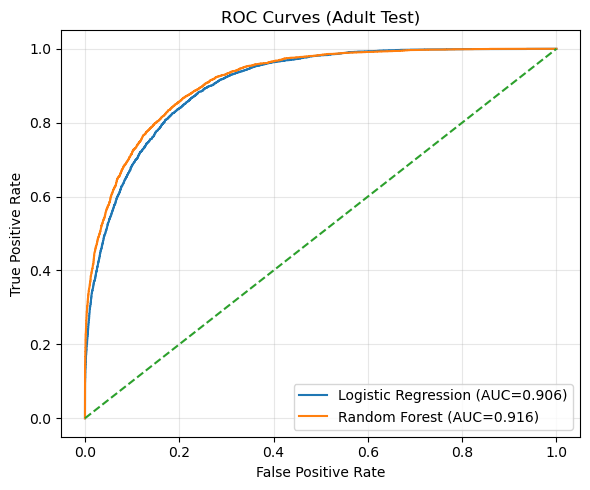

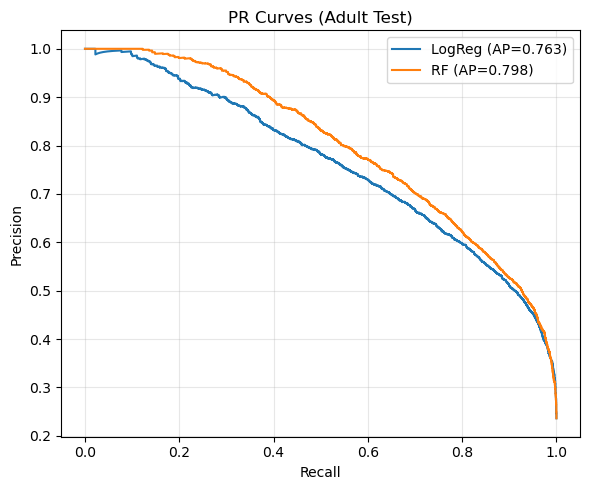

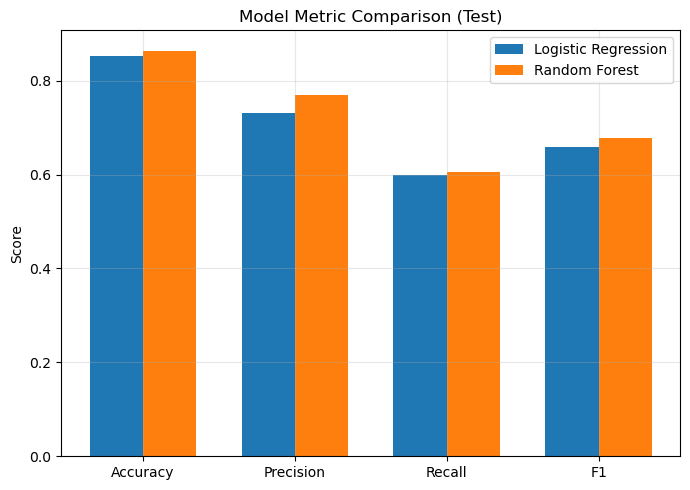

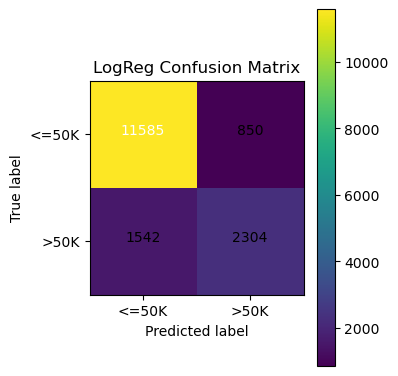

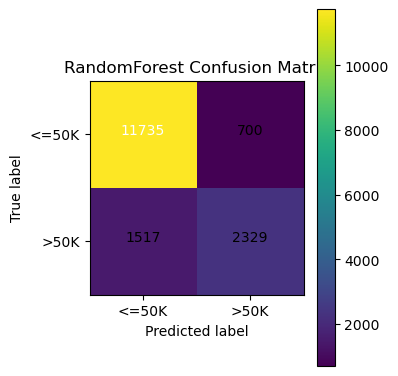

Saved figures: roc_curves.png, pr_curves.png, metric_bars.png, cm_logreg.png, cm_rf.png


In [35]:
# ROC curves
plt.figure(figsize=(6,5))
for res in [lr_res, rf_res]:
    if not np.isnan(res['auc']):
        fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
        plt.plot(fpr, tpr, label=f"{res['name']} (AUC={res['auc']:.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Adult Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=300)
plt.show()

# PR curves
from sklearn.metrics import precision_recall_curve, average_precision_score
plt.figure(figsize=(6,5))
for name, res in [("LogReg", lr_res), ("RF", rf_res)]:
    if not np.isnan(res['auc']):
        p, r, _ = precision_recall_curve(y_test, res['y_proba'])
        ap = average_precision_score(y_test, res['y_proba'])
        plt.plot(r, p, label=f"{name} (AP={ap:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); 
plt.title("PR Curves (Adult Test)")
plt.legend(); 
plt.grid(alpha=0.3); 
plt.tight_layout(); 
plt.savefig("pr_curves.png", dpi=300); 
plt.show()

# Metric bars
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
lr_vals = [lr_res['acc'], lr_res['precision'], lr_res['recall'], lr_res['f1']]
rf_vals = [rf_res['acc'], rf_res['precision'], rf_res['recall'], rf_res['f1']]

x = np.arange(len(labels))
w = 0.35
plt.figure(figsize=(7,5))
plt.bar(x - w/2, lr_vals, w, label='Logistic Regression')
plt.bar(x + w/2, rf_vals, w, label='Random Forest')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Model Metric Comparison (Test)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("metric_bars.png", dpi=300)
plt.show()

# Confusion matrices
def plot_cm(cm, title, filename):
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['<=50K', '>50K'])
    plt.yticks(tick_marks, ['<=50K', '>50K'])
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

plot_cm(lr_res['cm'], "LogReg Confusion Matrix", "cm_logreg.png")
plot_cm(rf_res['cm'], "RandomForest Confusion Matrix", "cm_rf.png")

print("Saved figures: roc_curves.png, pr_curves.png, metric_bars.png, cm_logreg.png, cm_rf.png")

## 10) Analysis of results and conclusions

In [38]:
print("Analysis of results and conclusions")
print("="*60)

# Determining the Optimal Model (Primarily Based on F1)
lr_f1, rf_f1 = lr_res['f1'], rf_res['f1']
lr_auc, rf_auc = lr_res['auc'], rf_res['auc']

if lr_f1 > rf_f1:
    best_model = "Logistic Regression"
    best_f1, other_f1 = lr_f1, rf_f1
    best_auc, other_auc = lr_auc, rf_auc
else:
    best_model = "Random Forest"
    best_f1, other_f1 = rf_f1, lr_f1
    best_auc, other_auc = rf_auc, lr_auc

print(f"🏆 Best model: {best_model}")
print(f"📈 F1 based selection: {best_model} 's F1 score ({best_f1:.4f}) is higher than {other_f1:.4f}")

# Statistics and Feature Dimension Information
try:
    pre_lr = log_reg_search.best_estimator_.named_steps['pre']
    X_train_processed = pre_lr.transform(X_train)
    final_dim = X_train_processed.shape[1]
except Exception:
    # If logistic regression pipeline is unavailable, use random forest's
    pre_rf = rf_search.best_estimator_.named_steps['pre']
    X_train_processed = pre_rf.transform(X_train)
    final_dim = X_train_processed.shape[1]

# Calculate the “total number of missing values processed”
missing_total = None
try:
    tmp_train, tmp_test = try_load_adult()  # The ‘?’ has been parsed as NaN during reading
    missing_total = int(tmp_train.isna().sum().sum() + tmp_test.isna().sum().sum())
except Exception:
    pass

print("\n📋 Detailed Analysis:")
if missing_total is not None:
    print(f"1. Data Preprocessing:")
    print(f"   - Processed {missing_total} missing values")
else:
    print(f"1. Data Preprocessing:")
    print(f"   - Missing values imputed using median/mode")
print(f"   - Numeric features standardized, categorical features one-hot encoded（drop='first'，handle_unknown='ignore'）")
print(f"   - Final feature dimension: {final_dim}")

# Model Configuration
print(f"\n2. Model Configuration:")
print(f"   - Logistic Regression optimal parameters: {log_reg_search.best_params_}")
print(f"   - Random Forest optimal parameters: {rf_search.best_params_}")

# Performance Summary
best_acc = max(lr_res['acc'], rf_res['acc'])
def _fmt_auc(x):
    return "NaN" if (x is None or (isinstance(x, float) and np.isnan(x))) else f"{x:.4f}"

print(f"\n3. Performance Summary:")
print(f"   - Best Accuracy: {best_acc:.4f}")
print(f"   - Best F1: {best_f1:.4f}")
print(f"   - Best AUC: {_fmt_auc(best_auc)}")

# Efficiency Comparison
lr_pred_time, rf_pred_time = lr_res['pred_time'], rf_res['pred_time']

print(f"\n4. Efficiency Comparison:")
print(f"   - Training Speed: {'Logistic Regression' if lr_train_time < rf_train_time else 'Random Forest'} is faster "
      f"(LR: {lr_train_time:.4f}s, RF: {rf_train_time:.4f}s)")
print(f"   - Prediction Speed: {'Logistic Regression' if lr_pred_time < rf_pred_time else 'Random Forest'} is faster "
      f"(LR: {lr_pred_time:.4f}s, RF: {rf_pred_time:.4f}s)")

# Conclusion
print(f"\n🎯 Conclusion:")
print(f"Based on test set performance,{best_model} demonstrates overall superiority on the Census Income dataset, "
      f"achieving better results on key evaluation metrics (especially F1 score) while maintaining acceptable computational efficiency.")

Analysis of results and conclusions
🏆 Best model: Random Forest
📈 F1 based selection: Random Forest 's F1 score (0.6775) is higher than 0.6583
Loaded from UCI URLs.

📋 Detailed Analysis:
1. Data Preprocessing:
   - Processed 6465 missing values
   - Numeric features standardized, categorical features one-hot encoded（drop='first'，handle_unknown='ignore'）
   - Final feature dimension: 100

2. Model Configuration:
   - Logistic Regression optimal parameters: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
   - Random Forest optimal parameters: {'clf__max_depth': None, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

3. Performance Summary:
   - Best Accuracy: 0.8638
   - Best F1: 0.6775
   - Best AUC: 0.9156

4. Efficiency Comparison:
   - Training Speed: Logistic Regression is faster (LR: 3.2563s, RF: 42.4172s)
   - Prediction Speed: Logistic Regression is faster (LR: 0.0264s, RF: 0.2277s)

🎯 Conclusion:
Based on test set performance,Rando